In [1]:
import os
import numpy as np
import pandas as pd
import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import geopandas as gp
import sklearn.preprocessing

In [2]:
# Read in the CSVs from the data folder

# find files
data_dir = "../data"
files = [os.path.join(data_dir,x) for x in os.listdir("../data") if x.endswith(".txt") or x.endswith(".csv")]

# read as dataframes
p = pd.read_csv(files[0])
q = pd.read_csv(files[1])
et = pd.read_csv(files[2])
ds = pd.read_csv(files[3], sep='\t', header=0)

# set indices as time
p.set_index(p.columns[0], inplace=True)
q.set_index(q.columns[0], inplace = True)
et.set_index(et.columns[0], inplace = True)


ds.set_index(ds['dt'], inplace = True)

# convert to datetime
ds.index = pd.to_datetime(ds.index)
p.index = pd.to_datetime(p.index)
q.index = pd.to_datetime(q.index)
et.index = pd.to_datetime(et.index)

# Change the ds index to be beginning of the month
ds.index += datetime.timedelta(days = 1)

# Merge the dfs
p_q = pd.merge(p,q, left_index=True, right_index=True)
p_q_et = pd.merge(p_q, et, left_index=True, right_index=True)

# Set the timezones to none
p_q_et = p_q_et.tz_localize(None).copy()
ds = ds.tz_localize(None).copy()

# Merge again
df = pd.merge(p_q_et, ds, left_index=True, right_index=True)

# Drop irrelevant columns
df.drop(["region", 'dt'], axis = 1, inplace = True)

In [3]:
df.head()

,trmm,prism,chirps,discharge_cms,modis,gldas,gridmet,s
2001-01-01,1.093282e+07,5.273174e+06,3.062379e+06,368.118400,1.773670e+06,4.593587e+05,1.174011e+06,4580.215098
2001-02-01,1.432065e+07,6.721928e+06,3.510050e+06,504.039040,1.534297e+06,6.572096e+05,1.345984e+06,4580.902281
2001-03-01,6.189033e+06,3.217688e+06,2.264511e+06,903.305920,2.761055e+06,1.421961e+06,2.199432e+06,4581.688633
2001-04-01,7.002581e+06,3.531893e+06,1.728371e+06,393.603520,2.159400e+06,1.913153e+06,2.520901e+06,4582.127895
2001-05-01,2.803792e+05,2.534074e+05,2.999343e+05,262.496736,2.787220e+06,2.552808e+06,2.110090e+06,4581.939481


In [4]:
# Get the area over which precip and ET were calculated over
hu4 = gp.read_file("../shape/cv_hu6.shp")
study_area = hu4.AreaSqKm.values
study_area = study_area * 1000000. # sq km to sq m

# Now convert to the appropriate units

df['q'] = df.discharge_cms*2.628e+6 # convert cms to cubic m/month
df['p'] = df.prism*study_area * 1e-3 # multiply by study area and convert mm to m
df['et_gridmet'] = df.gridmet*study_area * 1e-3 # multiply by study area and convert mm to m
df['et_modis'] = df.modis*study_area * 1e-3 # multiply by study area and convert mm to m
df['s_m3'] = df.s * 1.23348e+9 # convert from million acre ft to cubic m 

In [5]:
# df['ds_mod'] = df.p - df.et_modis - df.q
# df['ds_gridmet'] = df.p - df.et_gridmet - df.q

df['ds'] = df.p - df.et_gridmet - df.q

/Users/aakashahamed/anaconda3/envs/tc/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


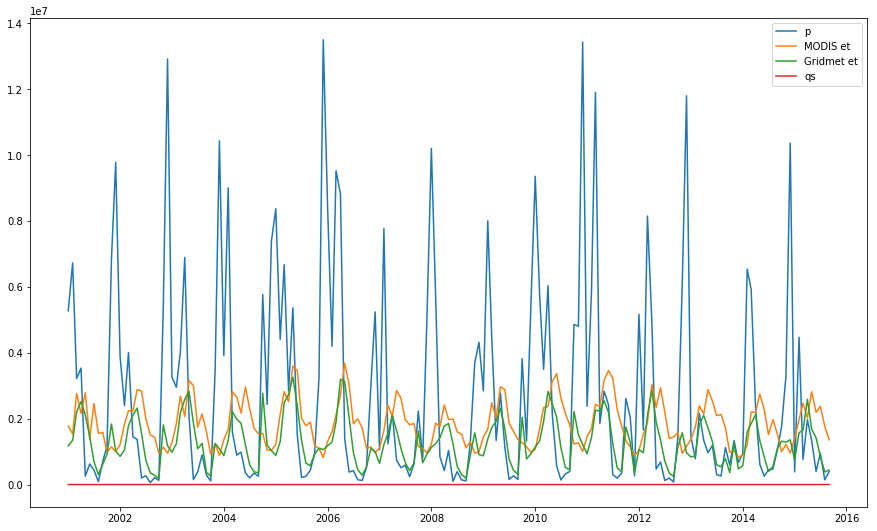

In [6]:
plt.figure(figsize = (15, 9))

plt.plot(df.index,df['prism'], label = "p")
plt.plot(df.index,df['modis'], label = "MODIS et")
plt.plot(df.index,df['gridmet'], label = "Gridmet et")
plt.plot(df.index,df['discharge_cms'], label = "qs")

plt.legend()
plt.show()

In [7]:
# Compute annual ds sums from ds = P - ET - Q:
years = np.arange(df.index[0].year, df.index[-1].year+1)

sums = {}

for year in years:
    year_df = df[df.index.year == year]
    year_sum = np.sum(year_df['ds'])
    sums[year] = year_sum
    

In [8]:
# Compute annual ds sums from ds = P - ET - Q:
years = np.arange(df.index[0].year, df.index[-1].year-1)

rs_sums = {}
c2v_sums = {}

startmonth = 11

for year in years:

    # Select df for nov and the first year
    ydf1 = df.iloc[df.index.year == year]
    mdf1 = ydf1.iloc[ydf1.index.month == startmonth]
    
    # advance a year and select df
    nextyear_df = df.iloc[df.index.year == year+1]
    nextmonth_df = nextyear_df.iloc[nextyear_df.index.month == startmonth-1]
    
    # subset original df based on start and end indices
    hydro_year_df = df.loc[mdf1.index[0] : nextmonth_df.index[0]]
    
    # compute the sums
    c2v_sums[year] = hydro_year_df['s_m3'][-1] - hydro_year_df['s_m3'][0]
    rs_sums[year] = hydro_year_df['ds'].sum()
    

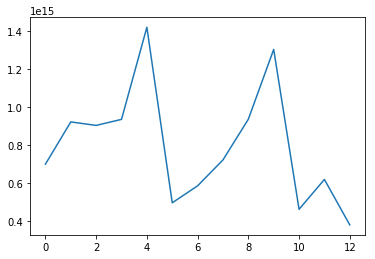

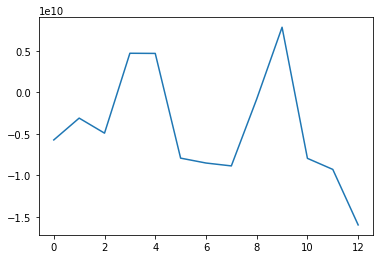

In [9]:
plt.plot(rs_sums.values())
plt.show()
plt.plot(c2v_sums.values())
plt.show()

In [10]:
dt_idx = pd.date_range(start=df.index[0], end=df.index[-1] + relativedelta(years=1),  freq='Y')
ds_df = pd.DataFrame({'ds':list(rs_sums.values()), 'c2vds': list(c2v_sums.values())})

ds_df.head()

,ds,c2vds
0,6.996831e+14,-5.718579e+09
1,9.226490e+14,-3.089006e+09
2,9.042496e+14,-4.900562e+09
3,9.360441e+14,4.726428e+09
4,1.422262e+15,4.707250e+09


# Scaling: 
## $ X_{scaled} = \frac{X_i - \mu}{\sigma_x}$

In [11]:
mms = sklearn.preprocessing.StandardScaler()

scaled = []

for i in [ds_df['ds'],ds_df['c2vds'],df['s_m3']]:
    i = i[~np.isnan(i)]
    j = np.array(i).reshape(-1,1)
    out = mms.fit_transform(j)
    scaled.append(out)


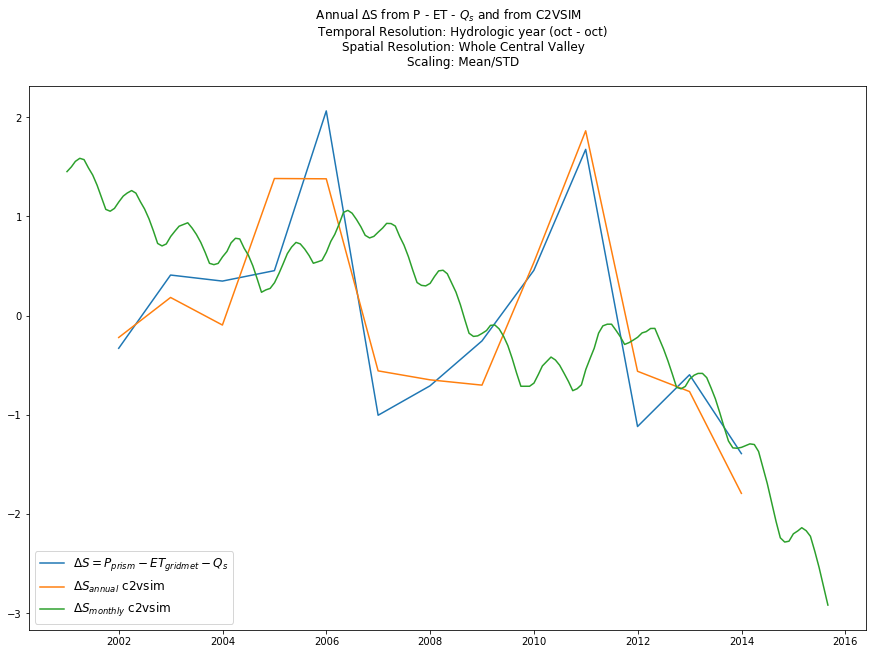

In [12]:
plt.figure(figsize=(15,10))

plt.title(
    """ Annual $\Delta$S from P - ET - $Q_s$ and from C2VSIM
        Temporal Resolution: Hydrologic year (oct - oct)
        Spatial Resolution: Whole Central Valley
        Scaling: Mean/STD
    """)

plt.plot(dt_idx[:-2], scaled[0], label = "$\Delta S = P_{prism} - ET_{gridmet} - Q_{s}$")

plt.plot(dt_idx[:-2], scaled[1], label = "$\Delta S_{annual}$ c2vsim")

plt.plot(df.index, scaled[2], label = "$\Delta S_{monthly}$ c2vsim")

# plt.savefig("../figs/hydro_year_balance.png")

plt.legend(loc="lower left", fontsize = 'large')

plt.show()

# Inverse transform the scaled data

In [15]:
inverted = []
for i in scaled:
    inverted.append(mms.inverse_transform(i))

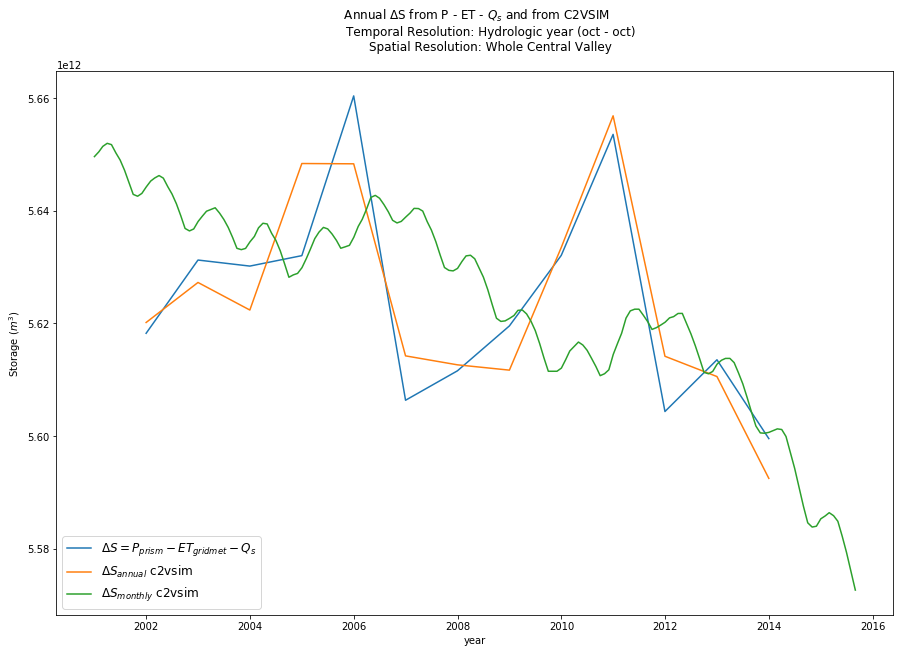

In [21]:
plt.figure(figsize=(15,10))

plt.title(
    """ Annual $\Delta$S from P - ET - $Q_s$ and from C2VSIM
        Temporal Resolution: Hydrologic year (oct - oct)
        Spatial Resolution: Whole Central Valley
    """)

plt.plot(dt_idx[:-2], inverted[0], label = "$\Delta S = P_{prism} - ET_{gridmet} - Q_{s}$")

plt.plot(dt_idx[:-2], inverted[1], label = "$\Delta S_{annual}$ c2vsim")

plt.plot(df.index, inverted[2], label = "$\Delta S_{monthly}$ c2vsim")

plt.legend(loc="lower left", fontsize = 'large')
plt.ylabel("Storage $(m^{3})$")
plt.xlabel("year")

plt.savefig("../figs/hydro_year_balance_absolute.png")

plt.show()